In [250]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [251]:
concatenated_df= pd.read_csv('Dataset/Concat_dataframe.csv')
concatenated_df

,HCHO reading,Location,Current Date,Next Date,Year,Month
0,0.000263,"Deniyaya, Matara",2019-01-01,2019-01-02,2019,1
1,0.000263,Nuwara Eliya Proper,2019-01-01,2019-01-02,2019,1
2,0.000263,Colombo Proper,2019-01-02,2019-01-03,2019,1
3,0.000006,"Deniyaya, Matara",2019-01-02,2019-01-03,2019,1
4,0.000006,Nuwara Eliya Proper,2019-01-02,2019-01-03,2019,1
...,...,...,...,...,...,...
12774,0.000158,Kurunegala Proper,2023-12-30,2023-12-31,2023,12
12775,0.000117,Jaffna Proper,2023-12-30,2023-12-31,2023,12
12776,0.000117,"Bibile, Monaragala",2023-12-31,2024-01-01,2023,12
12777,0.000065,Kurunegala Proper,2023-12-31,2024-01-01,2023,12


In [252]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(concatenated_df['HCHO reading'])

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# Based on the p-value, decide on stationarity
if adf_test[1] > 0.05:
    print("The series is likely non-stationary and may need differencing.")
else:
    print("The series is likely stationary.")

ADF Statistic: -11.898903
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
The series is likely stationary.


In [253]:
# Convert 'Current Date' to datetime and set as index
concatenated_df['Current Date'] = pd.to_datetime(concatenated_df['Current Date'])
concatenated_df.set_index('Current Date', inplace=True)

# Output the first few rows and the index to verify changes
df_head_after = concatenated_df.head()
df_index_info = concatenated_df.index

df_head_after, df_index_info

(              HCHO reading             Location   Next Date  Year  Month
 Current Date                                                            
 2019-01-01        0.000263     Deniyaya, Matara  2019-01-02  2019      1
 2019-01-01        0.000263  Nuwara Eliya Proper  2019-01-02  2019      1
 2019-01-02        0.000263       Colombo Proper  2019-01-03  2019      1
 2019-01-02        0.000006     Deniyaya, Matara  2019-01-03  2019      1
 2019-01-02        0.000006  Nuwara Eliya Proper  2019-01-03  2019      1,
 DatetimeIndex(['2019-01-01', '2019-01-01', '2019-01-02', '2019-01-02',
                '2019-01-02', '2019-01-03', '2019-01-03', '2019-01-03',
                '2019-01-04', '2019-01-04',
                ...
                '2023-12-28', '2023-12-29', '2023-12-29', '2023-12-29',
                '2023-12-30', '2023-12-30', '2023-12-30', '2023-12-31',
                '2023-12-31', '2023-12-31'],
               dtype='datetime64[ns]', name='Current Date', length=12779, freq=None)

# Colombo Proper

In [254]:
# Selecting data 
colombo_df = concatenated_df[concatenated_df['Location'] == 'Colombo Proper']

In [255]:
split_ratio = 0.8
train_size = int(len(colombo_df) * split_ratio)
train_data, test_data = colombo_df[0:train_size], colombo_df[train_size:]
colombo_shape = train_data.shape
colombo_shape

(1460, 5)

In [256]:
# Calculate ACF and PACF
colombo_series = concatenated_df[concatenated_df['Location'] == 'Colombo Proper']['HCHO reading']
lag_acf = acf(colombo_series, nlags=20)
lag_pacf = pacf(colombo_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

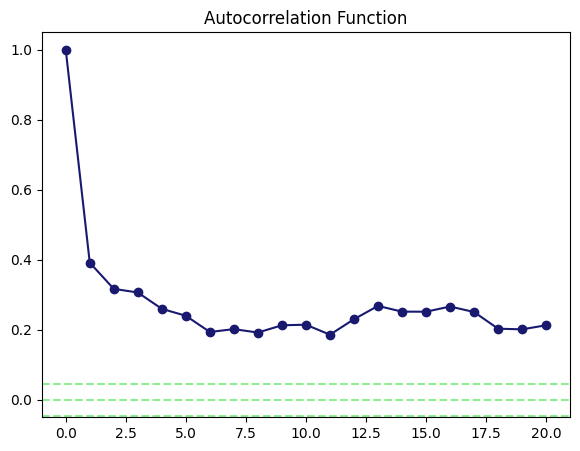

In [257]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(colombo_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(colombo_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

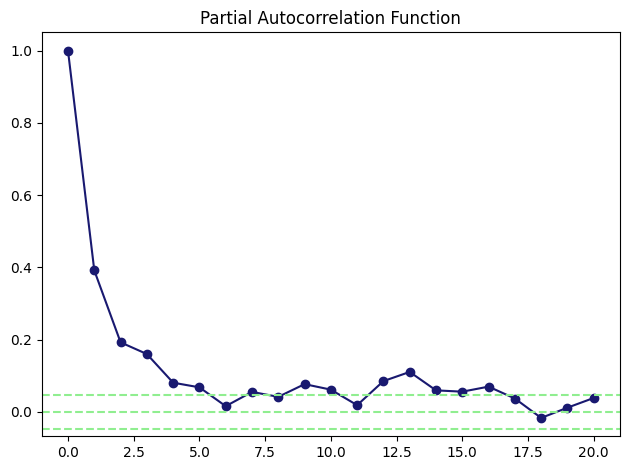

In [258]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(colombo_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(colombo_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [259]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(colombo_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast)  
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  


# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.0002281548774214526
MSE: 5.205464809119806e-08
MAE: 0.019597671025727962


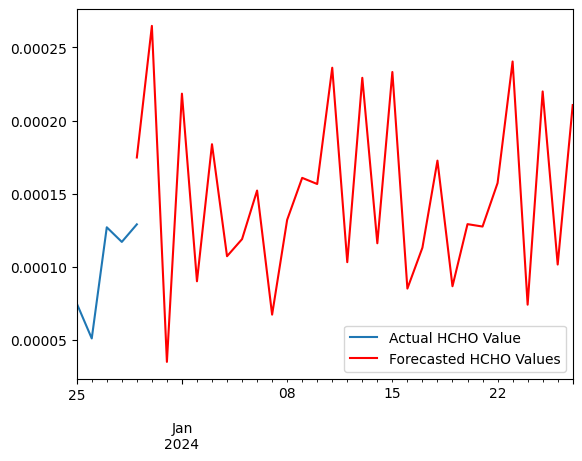

In [260]:
sarima_model = SARIMAX(colombo_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)

last_index = colombo_df.index[-4]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

colombo_data = pd.DataFrame({'HCHO reading': [0.000075, 0.000051, 0.000127, 0.000117, 0.000129]},
                      index=pd.date_range('2023-12-25', periods=5, freq='D'))

colombo_data["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()

# Kurunegala Proper

In [261]:
kurunegala_df = concatenated_df[concatenated_df['Location'] == 'Kurunegala Proper']
kurunegala_df

,HCHO reading,Location,Next Date,Year,Month
Current Date,,,,,
2019-01-01,0.000088,Kurunegala Proper,2019-01-02,2019,1
2019-01-02,0.000137,Kurunegala Proper,2019-01-03,2019,1
2019-01-03,0.000148,Kurunegala Proper,2019-01-04,2019,1
2019-01-04,-0.000002,Kurunegala Proper,2019-01-05,2019,1
2019-01-05,0.000249,Kurunegala Proper,2019-01-06,2019,1
...,...,...,...,...,...
2023-12-27,0.000075,Kurunegala Proper,2023-12-28,2023,12
2023-12-28,0.000051,Kurunegala Proper,2023-12-29,2023,12
2023-12-29,0.000127,Kurunegala Proper,2023-12-30,2023,12


In [262]:
split_ratio = 0.8
train_size = int(len(kurunegala_df) * split_ratio)
train_data, test_data = kurunegala_df[0:train_size], kurunegala_df[train_size:]
kurunegala_shape = train_data.shape
kurunegala_shape

(1460, 5)

In [263]:
# Calculate ACF and PACF
kurunegala_series = concatenated_df[concatenated_df['Location'] == 'Kurunegala Proper']['HCHO reading']
lag_acf = acf(kurunegala_series, nlags=20)
lag_pacf = pacf(kurunegala_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

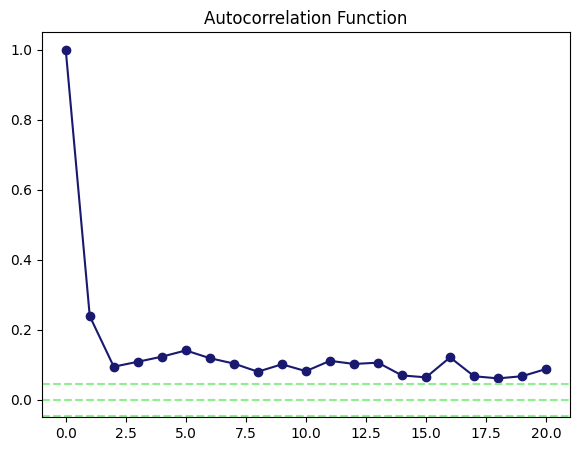

In [264]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(kurunegala_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(kurunegala_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

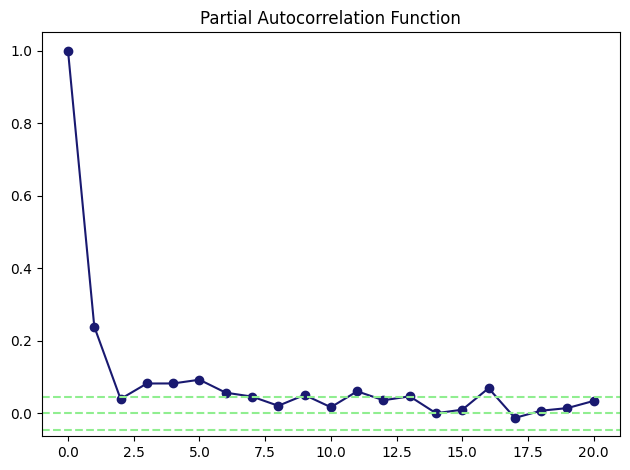

In [265]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(kurunegala_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(kurunegala_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [266]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(kurunegala_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast)  
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.0003598435626844032
MSE: 1.2948738960540402e-07
MAE: 0.031121378335009272


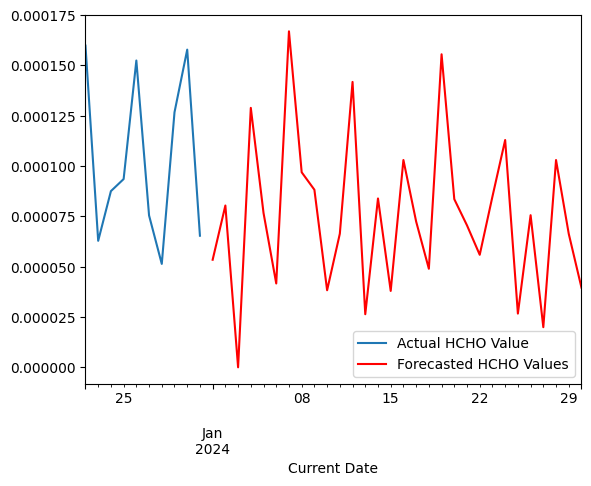

In [267]:
sarima_model = SARIMAX(kurunegala_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
kurunegala_df["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()

# Monaragala 

In [268]:
monaragala_df = concatenated_df[concatenated_df['Location'] == 'Bibile, Monaragala']
monaragala_df

,HCHO reading,Location,Next Date,Year,Month
Current Date,,,,,
2019-01-02,1.919915e-05,"Bibile, Monaragala",2019-01-03,2019,1
2019-01-03,2.811448e-05,"Bibile, Monaragala",2019-01-04,2019,1
2019-01-04,3.747998e-05,"Bibile, Monaragala",2019-01-05,2019,1
2019-01-05,-1.798261e-05,"Bibile, Monaragala",2019-01-06,2019,1
2019-01-06,1.457837e-04,"Bibile, Monaragala",2019-01-07,2019,1
...,...,...,...,...,...
2023-12-27,-7.696313e-08,"Bibile, Monaragala",2023-12-28,2023,12
2023-12-28,7.547085e-05,"Bibile, Monaragala",2023-12-29,2023,12
2023-12-29,5.139770e-05,"Bibile, Monaragala",2023-12-30,2023,12


In [269]:
split_ratio = 0.8
train_size = int(len(monaragala_df) * split_ratio)
train_data, test_data = monaragala_df[0:train_size], monaragala_df[train_size:]
monaragala_shape = train_data.shape
monaragala_shape

(1460, 5)

In [270]:
# Calculate ACF and PACF
monaragala_series = concatenated_df[concatenated_df['Location'] == 'Bibile, Monaragala']['HCHO reading']
lag_acf = acf(monaragala_series, nlags=20)
lag_pacf = pacf(monaragala_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

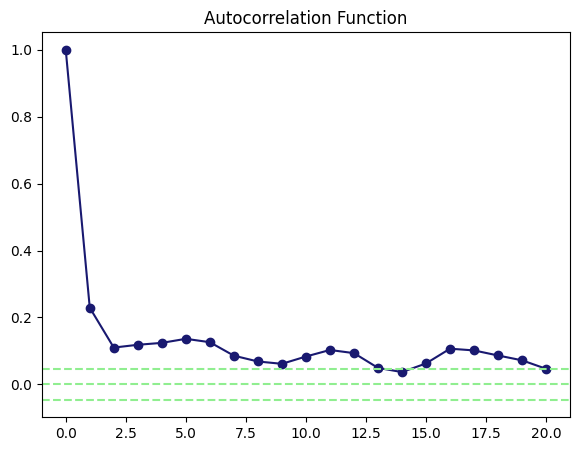

In [271]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(monaragala_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(monaragala_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

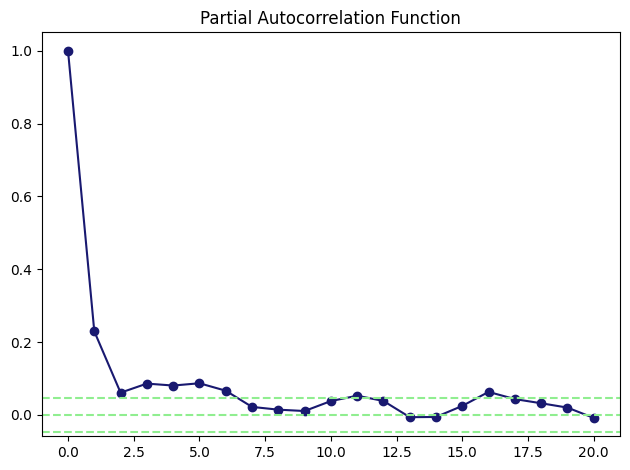

In [272]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(monaragala_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(monaragala_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [273]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(monaragala_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast) 
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  


# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.0002474982051892619
MSE: 6.1255361571906e-08
MAE: 0.02131839800424241


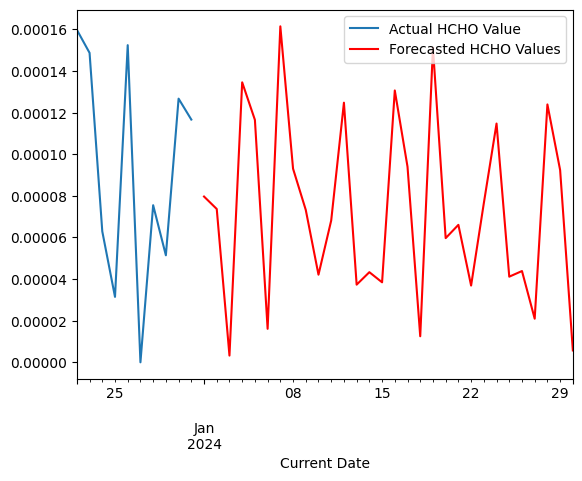

In [274]:
sarima_model = SARIMAX(monaragala_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
monaragala_df["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()

# Matara 

In [275]:
# Selecting the data for the model
matara_df = concatenated_df[concatenated_df['Location'] == 'Deniyaya, Matara']
matara_df

,HCHO reading,Location,Next Date,Year,Month
Current Date,,,,,
2019-01-01,0.000263,"Deniyaya, Matara",2019-01-02,2019,1
2019-01-02,0.000006,"Deniyaya, Matara",2019-01-03,2019,1
2019-01-03,0.000236,"Deniyaya, Matara",2019-01-04,2019,1
2019-01-04,0.000064,"Deniyaya, Matara",2019-01-05,2019,1
2019-01-05,0.000053,"Deniyaya, Matara",2019-01-06,2019,1
...,...,...,...,...,...
2023-12-27,0.000228,"Deniyaya, Matara",2023-12-28,2023,12
2023-12-28,0.000228,"Deniyaya, Matara",2023-12-29,2023,12
2023-12-29,0.000140,"Deniyaya, Matara",2023-12-30,2023,12


In [276]:
split_ratio = 0.8
train_size = int(len(matara_df) * split_ratio)
train_data, test_data = matara_df[0:train_size], matara_df[train_size:]
matara_shape = train_data.shape
matara_shape

(1460, 5)

In [277]:
# Calculate ACF and PACF
matara_series = concatenated_df[concatenated_df['Location'] == 'Deniyaya, Matara']['HCHO reading']
lag_acf = acf(matara_series, nlags=20)
lag_pacf = pacf(matara_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

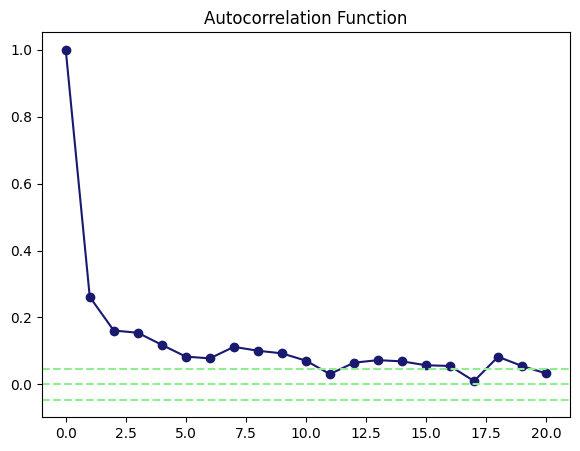

In [278]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(matara_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(matara_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

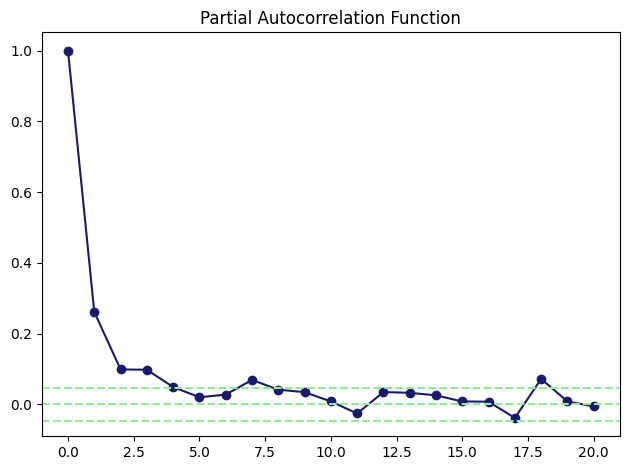

In [279]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(matara_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(matara_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [280]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(matara_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast)  
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.0004007292822713088
MSE: 1.605839576696783e-07
MAE: 0.034652902900511234


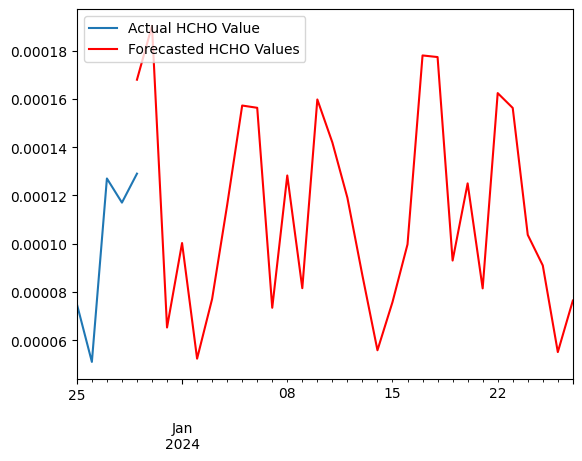

In [281]:
sarima_model = SARIMAX(matara_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)

last_index = matara_df.index[-4]
new_index = pd.date_range(start=last_index, periods=31, freq='D')[1:]

# Generating forecast
forecast = sarima_result.forecast(steps=30, index=new_index)

matara_data = pd.DataFrame({'HCHO reading': [0.000075, 0.000051, 0.000127, 0.000117, 0.000129]},
                      index=pd.date_range('2023-12-25', periods=5, freq='D'))

matara_data["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()

# Jaffna Proper

In [282]:
# Selecting the data for the model
jaffna_df = concatenated_df[concatenated_df['Location'] == 'Jaffna Proper']
jaffna_df

,HCHO reading,Location,Next Date,Year,Month
Current Date,,,,,
2019-01-01,0.000058,Jaffna Proper,2019-01-02,2019,1
2019-01-02,0.000102,Jaffna Proper,2019-01-03,2019,1
2019-01-03,0.000039,Jaffna Proper,2019-01-04,2019,1
2019-01-04,-0.000002,Jaffna Proper,2019-01-05,2019,1
2019-01-05,0.000159,Jaffna Proper,2019-01-06,2019,1
...,...,...,...,...,...
2023-12-27,0.000075,Jaffna Proper,2023-12-28,2023,12
2023-12-28,0.000051,Jaffna Proper,2023-12-29,2023,12
2023-12-29,0.000127,Jaffna Proper,2023-12-30,2023,12


In [283]:
split_ratio = 0.8
train_size = int(len(jaffna_df) * split_ratio)
train_data, test_data = jaffna_df[0:train_size], jaffna_df[train_size:]
jaffna_shape = train_data.shape
jaffna_shape

(1460, 5)

In [284]:
# Calculate ACF and PACF
jaffna_series = concatenated_df[concatenated_df['Location'] == 'Jaffna Proper']['HCHO reading']
lag_acf = acf(jaffna_series, nlags=20)
lag_pacf = pacf(jaffna_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

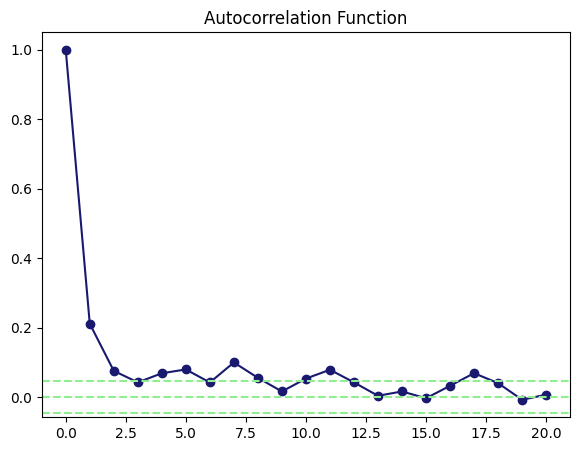

In [285]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(jaffna_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(jaffna_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

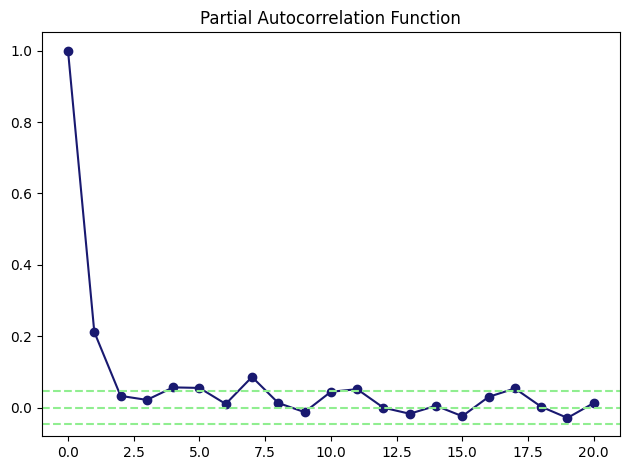

In [286]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(jaffna_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(jaffna_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [287]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(jaffna_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast)  
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.0001327786039604887
MSE: 1.7630157669696306e-08
MAE: 0.010846062496145788


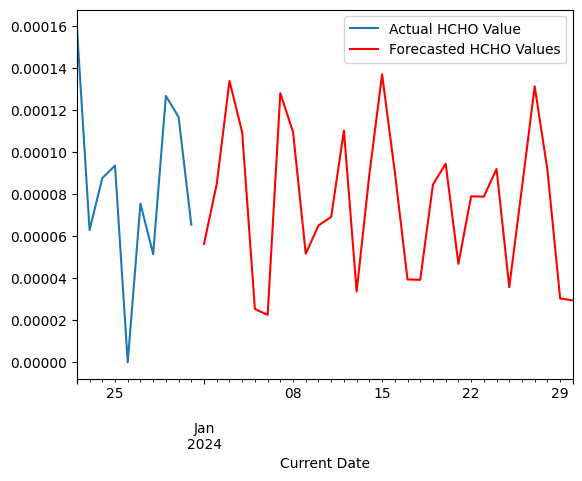

In [288]:
sarima_model = SARIMAX(jaffna_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
jaffna_df["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()

# Nuwara Eliya Proper

In [289]:
# Selecting the data for the model
nuwara_eliya_df = concatenated_df[concatenated_df['Location'] == 'Nuwara Eliya Proper']
nuwara_eliya_df

,HCHO reading,Location,Next Date,Year,Month
Current Date,,,,,
2019-01-01,0.000263,Nuwara Eliya Proper,2019-01-02,2019,1
2019-01-02,0.000006,Nuwara Eliya Proper,2019-01-03,2019,1
2019-01-03,0.000191,Nuwara Eliya Proper,2019-01-04,2019,1
2019-01-04,0.000051,Nuwara Eliya Proper,2019-01-05,2019,1
2019-01-05,0.000065,Nuwara Eliya Proper,2019-01-06,2019,1
...,...,...,...,...,...
2023-12-27,0.000228,Nuwara Eliya Proper,2023-12-28,2023,12
2023-12-28,0.000228,Nuwara Eliya Proper,2023-12-29,2023,12
2023-12-29,0.000140,Nuwara Eliya Proper,2023-12-30,2023,12


In [290]:
split_ratio = 0.8
train_size = int(len(nuwara_eliya_df) * split_ratio)
train_data, test_data = nuwara_eliya_df[0:train_size], nuwara_eliya_df[train_size:]
nuwara_eliya_shape = train_data.shape
nuwara_eliya_shape

(1460, 5)

In [291]:
# Calculate ACF and PACF
nuwara_eliya_series = concatenated_df[concatenated_df['Location'] == 'Nuwara Eliya Proper']['HCHO reading']
lag_acf = acf(nuwara_eliya_series, nlags=20)
lag_pacf = pacf(nuwara_eliya_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

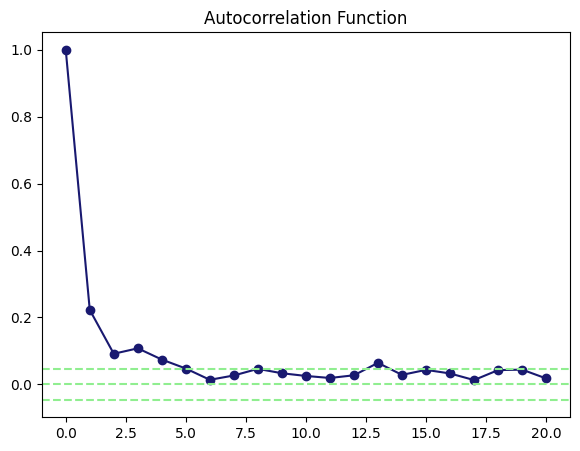

In [292]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(nuwara_eliya_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(nuwara_eliya_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

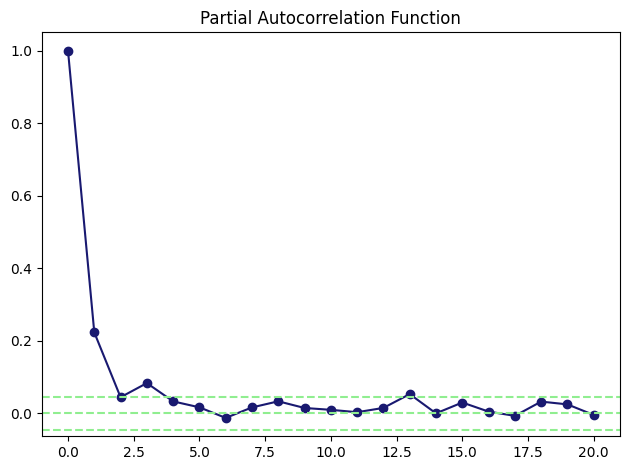

In [293]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(nuwara_eliya_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(nuwara_eliya_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [294]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(nuwara_eliya_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast)  
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.00016415846548662572
MSE: 2.694800179092369e-08
MAE: 0.013785933383821903


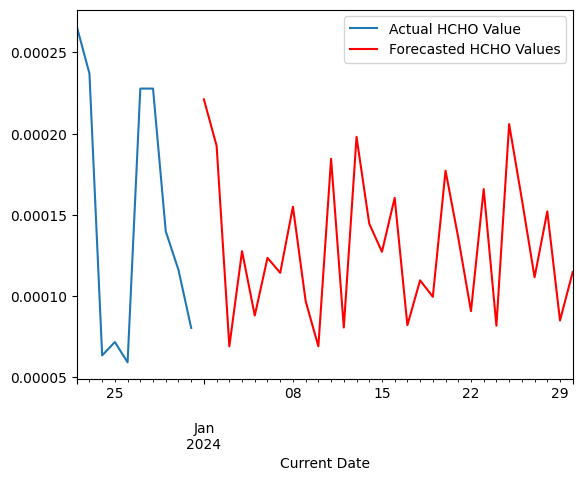

In [295]:
sarima_model = SARIMAX(nuwara_eliya_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
nuwara_eliya_df["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()

# Kandy Proper

In [296]:
kandy_df = concatenated_df[concatenated_df['Location'] == 'Kandy Proper']
kandy_df

,HCHO reading,Location,Next Date,Year,Month
Current Date,,,,,
2019-01-02,0.000092,Kandy Proper,2019-01-03,2019,1
2019-01-03,0.000092,Kandy Proper,2019-01-04,2019,1
2019-01-04,0.000191,Kandy Proper,2019-01-05,2019,1
2019-01-05,0.000122,Kandy Proper,2019-01-06,2019,1
2019-01-06,-0.000065,Kandy Proper,2019-01-07,2019,1
...,...,...,...,...,...
2023-12-27,0.000056,Kandy Proper,2023-12-28,2023,12
2023-12-28,0.000056,Kandy Proper,2023-12-29,2023,12
2023-12-29,0.000056,Kandy Proper,2023-12-30,2023,12


In [297]:
split_ratio = 0.8
train_size = int(len(kandy_df) * split_ratio)
train_data, test_data = kandy_df[0:train_size], kandy_df[train_size:]
kandy_shape = train_data.shape
kandy_shape

(1460, 5)

In [298]:
# Calculate ACF and PACF
kandy_series = concatenated_df[concatenated_df['Location'] == 'Kandy Proper']['HCHO reading']
lag_acf = acf(kandy_series, nlags=20)
lag_pacf = pacf(kandy_series, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

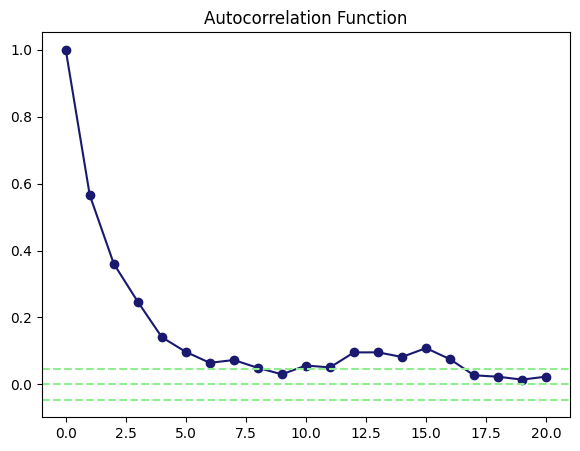

In [299]:
# Plot ACF
plt.figure(figsize=(15, 5))
plt.subplot(121) 
plt.plot(lag_acf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(kandy_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(kandy_series)), linestyle='--', color='lightgreen')
plt.title('Autocorrelation Function')

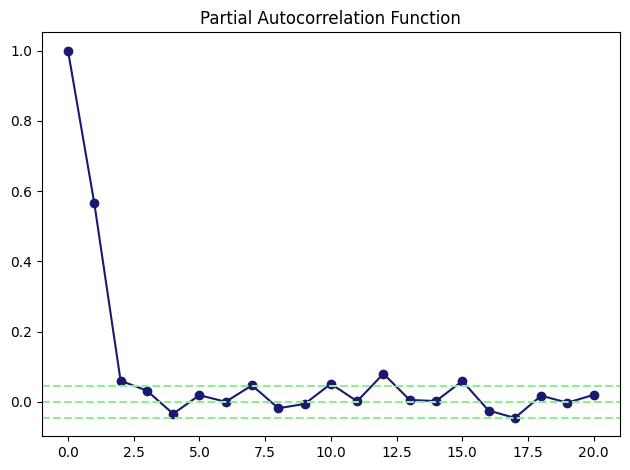

In [300]:
# Plot PACF
plt.plot(lag_pacf, marker='o', color='midnightblue')
plt.axhline(y=0, linestyle='--', color='lightgreen')
plt.axhline(y=-1.96/np.sqrt(len(kandy_series)), linestyle='--', color='lightgreen')
plt.axhline(y=1.96/np.sqrt(len(kandy_series)), linestyle='--', color='lightgreen')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [301]:
# Define and fit the S-ARIMA model on training data
model = SARIMAX(kandy_df["HCHO reading"][0:1401], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()

# Forecast for test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate evaluation metrics on test data
rmse = mean_squared_error(test_data["HCHO reading"], forecast, squared=False)  
mse = mean_squared_error(test_data["HCHO reading"], forecast) 
mae = mean_absolute_error(test_data["HCHO reading"], forecast) * 100  

# Print the evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

RMSE: 0.0011757030887581917
MSE: 1.3822777529155527e-06
MAE: 0.10391261424349081


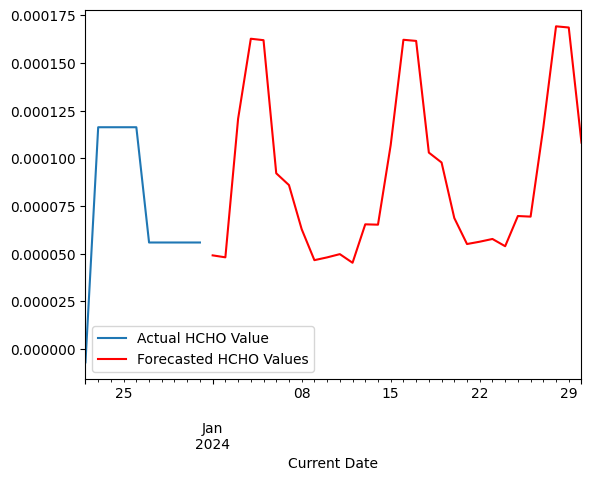

In [302]:
sarima_model = SARIMAX(kandy_df["HCHO reading"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Adjusting optimization parameters
sarima_result = sarima_model.fit()
# Generating forecast
forecast = sarima_result.forecast(steps=30)
kandy_df["HCHO reading"][-10:].plot(label="Actual HCHO Value")
forecast.plot(label="Forecasted HCHO Values", color='red')
plt.legend()